In [1]:
### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

### Custom functions
import modules as md
from utils.evaluation import phases_report, get_anaesthesia_phases

### Datasetpath
directory = 'data/'
datasetpath = 'dataset03/'
vitaldbpath = 'vitaldb_sevofl/'

bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

mac = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
mac.load('03_mac.npz')

In [2]:
def get_anaesthesia_phases_balanced(bis_dataset: np.array ,mac_dataset: np.array, N: int = 60) -> dict:
    anesthesia_phases = []
    
    for bis, mac in zip(bis_dataset, mac_dataset):
        conv_bis = np.convolve(bis[:,0], np.ones(N)/N, mode='valid')
        conv_mac = np.convolve(mac[:,0], np.ones(N)/N, mode='valid')
        index1 = np.argmax(conv_bis < 60) + 2 * N
        index2 = np.where(conv_mac > 0.5)[0][-1] - N
        anesthesia_phases.append([index1, index2])

    return anesthesia_phases

t1, t2 = get_anaesthesia_phases_balanced(bis.test_dataset, mac.test_dataset)[8]

t1*10/60, t2*10/60

(20.0, 263.0)

<Figure size 472.441x236.22 with 0 Axes>

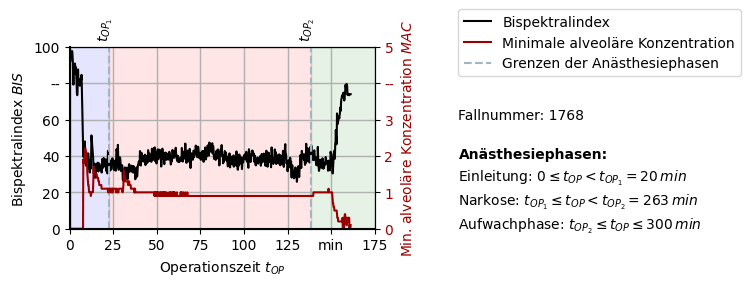

In [16]:
groundtruth = bis.test_dataset
mac_value = mac.test_dataset

phases = get_anaesthesia_phases_balanced(groundtruth, mac_value)

j = 1

end = np.where(groundtruth[j] == 0)[0][0]

time = np.arange(0, groundtruth[j,:end].shape[0]) * 10 / 60

groundtruth = groundtruth[j,:end]

plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

# Create the first plot
fig, ax1 = plt.subplots(figsize=(10/2.54, 6/2.54))
line1, = ax1.plot(time, groundtruth, color=color1, label='Bispektralindex')
line3 = ax1.vlines(phases[j][0]*10/60, ymin=0, ymax=100, color=color3, linestyles='dashed', label='Grenzen der Anästhesiephasen')
ax1.vlines(phases[j][1]*10/60, ymin=0, ymax=100, color=color3, linestyles='dashed')
ax1.text(phases[j][0]*10/60-7, 110, '$t_{OP_1}$', rotation=90, verticalalignment='center')
ax1.text(phases[j][1]*10/60-7, 110, '$t_{OP_2}$', rotation=90, verticalalignment='center')

ax1.set_xlabel('Operationszeit $t_{OP}$')
ax1.set_ylabel('Bispektralindex $BIS$')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linewidth=1.0)

# Create a second y-axis and the second plot
ax2 = ax1.twinx()
line2, = ax2.plot(time, mac_value[j,:end], color=color5, label='Minimale alveoläre Konzentration')
ax2.set_ylabel('Min. alveoläre Konzentration $MAC$', color=color5)
ax2.tick_params(axis='y', labelcolor=color5)

ax1.axvspan(0, phases[j][0]*10/60, color='blue', alpha=0.1)
ax1.axvspan(phases[j][0]*10/60, phases[j][1]*10/60, color='red', alpha=0.1)
ax1.axvspan(phases[j][1]*10/60, 300, color='green', alpha=0.1)

lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

ax1.legend(lines, labels, bbox_to_anchor=(1.25, 0.8))

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Limits
ax1.set_xlim(left=0, right=175)
ax1.set_ylim(bottom=0, top=100)
ax2.set_ylim(bottom=0, top=5)


# Einheiten auf x-Achse
xunit = 'min'
ticks = ax1.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks_with_units)

# Einheiten auf y1-Achse
yunit = '--'
ticks = ax1.get_yticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticks_with_units)

# Einheiten auf y2-Achse
yunit = '--'
ticks = ax2.get_yticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks_with_units)

t = 223
ax1.text(t, 60, s='Fallnummer: 1768')
ax1.text(t, 39, s='Anästhesiephasen:', fontweight='bold')
ax1.text(t, 26, s='Einleitung: $0 \leq t_{OP} < t_{OP_1} = 20 \, min$')
ax1.text(t, 13, s='Narkose: $t_{OP_1} \leq t_{OP} < t_{OP_2} = 263 \, min$')
ax1.text(t, 0, s='Aufwachphase: $t_{OP_2} \leq t_{OP} \leq 300 \, min$')

#plt.show()
plt.savefig('narkosephasen.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

# Entwicklung

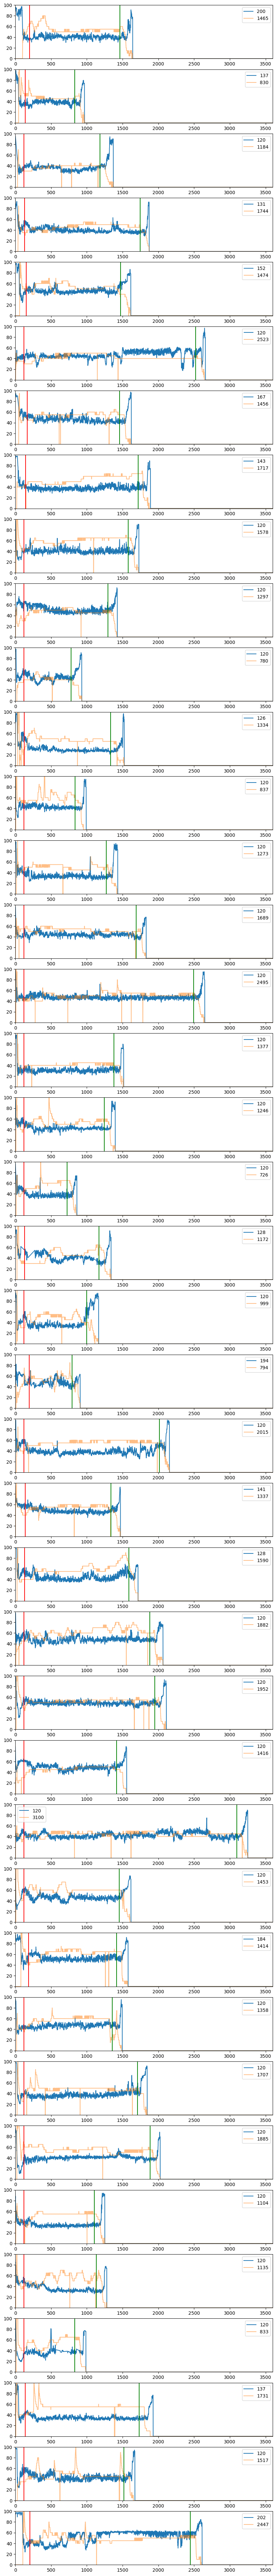

In [40]:
N = 60 # Number of samples to average 10min

train_index, val_index, test_index = bis.split(np.array(bis.index))

fig, axs = plt.subplots(bis.test_dataset.shape[0], 1, figsize=(10, 100))

for i, filename in enumerate(test_index):
    axs[i].plot(bis.test_dataset[i,:,0])
    axs[i].plot(mac.test_dataset[i,:,0]*50, alpha=0.5)

    axs[i].axis([0, 3600, 0, 100])

    index1, index2 = get_anaesthesia_phases_balanced(bis.test_dataset[i:i+1], mac.test_dataset[i:i+1])[0]

    axs[i].vlines(index1, 0, 100, colors='r')
    axs[i].vlines(index2, 0, 100, colors='g')

    axs[i].legend([index1,index2])